#Improving the classifier

In [80]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid') 
import sklearn as skl
import sklearn.metrics
import sklearn.learning_curve
import sklearn.ensemble
import sklearn.dummy
import numpy as np

import sys
sys.path = sys.path + ['..']
import get_airbnb_data
import db
from learning import *

In [112]:
sys.path

['',
 '/home/ibuder/anaconda3/lib/python34.zip',
 '/home/ibuder/anaconda3/lib/python3.4',
 '/home/ibuder/anaconda3/lib/python3.4/plat-linux',
 '/home/ibuder/anaconda3/lib/python3.4/lib-dynload',
 '/home/ibuder/anaconda3/lib/python3.4/site-packages/setuptools-17.0-py3.4.egg',
 '/home/ibuder/anaconda3/lib/python3.4/site-packages',
 '/home/ibuder/anaconda3/lib/python3.4/site-packages/Sphinx-1.3.1-py3.4.egg',
 '/home/ibuder/anaconda3/lib/python3.4/site-packages/cryptography-0.8.2-py3.4-linux-x86_64.egg',
 '/home/ibuder/anaconda3/lib/python3.4/site-packages/IPython/extensions',
 '..',
 '..',
 '..',
 '..',
 '..',
 '..']

In [3]:
engine = db.create_root_engine()
rawtable = pd.io.sql.read_sql_table('listings', engine, index_col='id')
Xtr, Xte, ytr, yte = get_training_test_set(rawtable, make_features=make_features2)

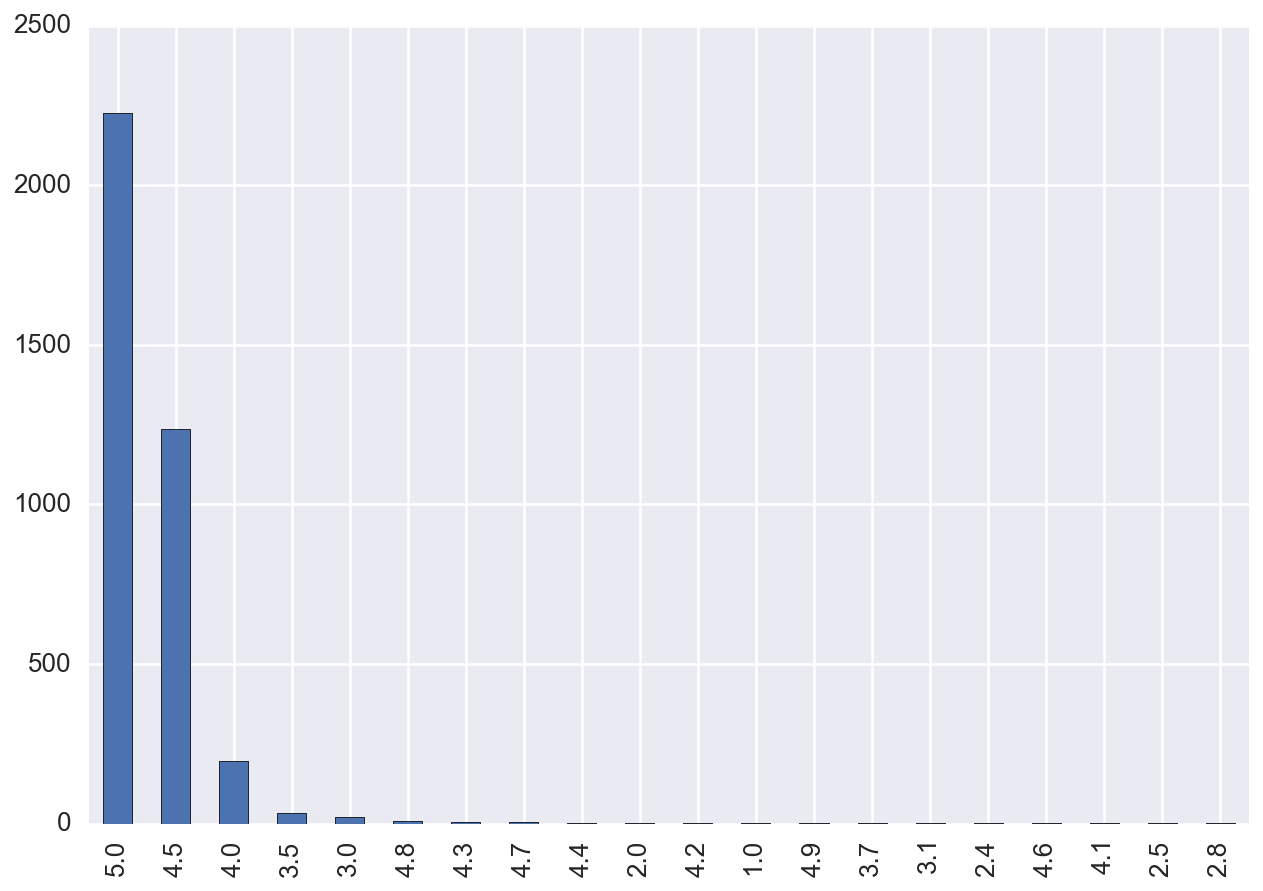

In [86]:
plt.rcParams['font.size'] = 20
matplotlib.rcParams.update({'font.size': 22})
rawtable.rating.value_counts().plot(kind='bar')

In [94]:
clf1 = get_logistic_regression_clf1()
clf1.fit(Xtr, ytr)
skl.metrics.f1_score(yte, clf1.predict(Xte), average=None)

array([ 0.06060606,  0.26573427,  0.74438812])

In [16]:
skl.metrics.accuracy_score(yte, clf1.predict(Xte))

0.61087420042643925

In [5]:
skl.metrics.log_loss(yte, clf1.predict_proba(Xte))

0.84833028537204058

In [28]:
scaler = skl.preprocessing.StandardScaler()
clf = skl.linear_model.LogisticRegression(multi_class='ovr', C=0.010, penalty='l2', class_weight=None)
clf2 = skl.pipeline.Pipeline([
        ('scaler', scaler), ('clf', clf)])
param_grid={'clf__C': np.logspace(-2, 2, num=10), 'clf__penalty': ('l1', 'l2',)}
gridclf2 = sklearn.grid_search.GridSearchCV(clf2, param_grid=param_grid, scoring='accuracy', 
                                            n_jobs=4, cv=3, verbose=1)

In [29]:
gridclf2.fit(Xtr, ytr)
skl.metrics.f1_score(yte, gridclf2.predict(Xte), average=None)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    6.5s finished


array([ 0.        ,  0.21428571,  0.75017593])

In [34]:
gridclf2.grid_scores_

[mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__penalty': 'l1'},
 mean: 0.59737, std: 0.00372, params: {'clf__C': 0.01, 'clf__penalty': 'l2'},
 mean: 0.60021, std: 0.00155, params: {'clf__C': 0.027825594022071243, 'clf__penalty': 'l1'},
 mean: 0.59737, std: 0.00372, params: {'clf__C': 0.027825594022071243, 'clf__penalty': 'l2'},
 mean: 0.60519, std: 0.00717, params: {'clf__C': 0.077426368268112694, 'clf__penalty': 'l1'},
 mean: 0.59453, std: 0.00158, params: {'clf__C': 0.077426368268112694, 'clf__penalty': 'l2'},
 mean: 0.60199, std: 0.00404, params: {'clf__C': 0.21544346900318834, 'clf__penalty': 'l1'},
 mean: 0.59346, std: 0.00277, params: {'clf__C': 0.21544346900318834, 'clf__penalty': 'l2'},
 mean: 0.59524, std: 0.00654, params: {'clf__C': 0.59948425031894093, 'clf__penalty': 'l1'},
 mean: 0.59346, std: 0.00438, params: {'clf__C': 0.59948425031894093, 'clf__penalty': 'l2'},
 mean: 0.59382, std: 0.00506, params: {'clf__C': 1.6681005372000592, 'clf__penalty': 'l1'},
 mea

In [31]:
gridclf2.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.077426368268112694, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0))])

In [32]:
skl.metrics.accuracy_score(yte, gridclf2.predict(Xte))

0.6130063965884861

In [33]:
skl.metrics.log_loss(yte, gridclf2.predict_proba(Xte))

0.82507307840818678

In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = sklearn.learning_curve.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fits



Fitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fits


Fitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fits

Fitting 3 folds for each of 20 candidates, totalling 60 fitsFitting 3 folds for each of 20 candidates, totalling 60 fits



/home/ibuder/anaconda3/lib/python3.4/site-packages/sklearn/grid_search.py:505: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for parameters in parameter_iterable
/home/ibuder/anaconda3/lib/python3.4/site-packages/sklearn/grid_search.py:505: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for parameters in parameter_iterable
/home/ibuder/anaconda3/lib/python3.4/site-packages/sklearn/grid_search.py:505: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for parameters in parameter_iterable
/home/ibuder/anaconda3/lib/python3.4/site-packages/sklearn/grid_search.py:505: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for parameters in parameter_iterable
[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[

<module 'matplotlib.pyplot' from '/home/ibuder/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

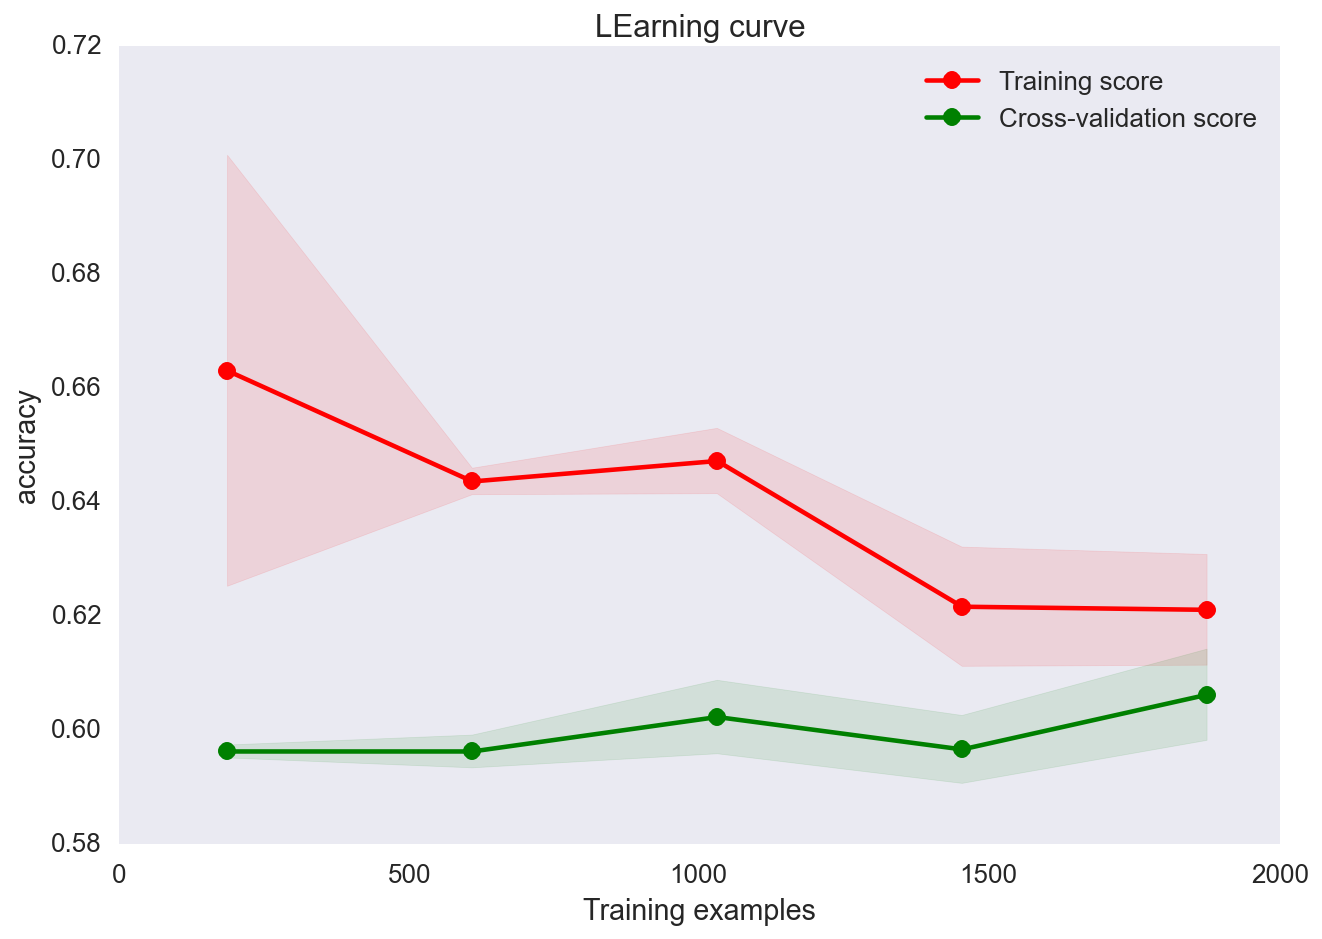

In [40]:
plot_learning_curve(gridclf2, "LEarning curve", Xtr, ytr)

#Need better training accuracy: more features or better models!

In [41]:
scaler = skl.preprocessing.StandardScaler()
clf = sklearn.svm.SVC(C=1.0, kernel='rbf', gamma=0.0, class_weight=None)
clf3 = skl.pipeline.Pipeline([
        ('scaler', scaler), ('clf', clf)])
param_grid={'clf__C': np.logspace(-2, 2, num=10), 'clf__gamma': np.logspace(-2, 2, num=10)}
gridclf3 = sklearn.grid_search.GridSearchCV(clf3, param_grid=param_grid, scoring='accuracy', 
                                            n_jobs=4, cv=3, verbose=1)

In [42]:
gridclf3.fit(Xtr, ytr)
skl.metrics.f1_score(yte, gridclf3.predict(Xte), average=None)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.8min finished


array([ 0.06060606,  0.13850416,  0.74672188])

In [43]:
gridclf3.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.6681005372000592, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.21544346900318834, kernel='rbf', max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False))])

In [44]:
gridclf3.grid_scores_

[mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 0.01},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 0.027825594022071243},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 0.077426368268112694},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 0.21544346900318834},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 0.59948425031894093},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 1.6681005372000592},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 4.6415888336127775},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 12.915496650148826},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 35.938136638046259},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.01, 'clf__gamma': 100.0},
 mean: 0.59701, std: 0.00052, params: {'clf__C': 0.027825594022071243, 'clf__gamma': 0.01},
 mean: 0.59701, std: 0.00052,

In [58]:
scaler = skl.preprocessing.StandardScaler()
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                              max_features='auto', # Can experiment with this to regularize
                                              n_jobs=4, verbose=1, class_weight='auto')
clf4 = skl.pipeline.Pipeline([
        ('scaler', scaler), ('clf', clf)])

In [59]:
clf4.fit(Xtr, ytr)
skl.metrics.f1_score(yte, clf4.predict(Xte), average=None)

[Parallel(n_jobs=4)]: Done   1 out of 249 | elapsed:    0.0s remaining:    3.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done   1 out of 532 | elapsed:    0.0s remaining:    9.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


array([ 0.06153846,  0.27431421,  0.76028369])

In [74]:
dict(1/yte.value_counts())

{'4-': 0.016129032258064516,
 '4.5-': 0.0031746031746031746,
 '5-': 0.0017825311942959001}

In [75]:
def make_weight(y):
    weight_dict = dict(1/y.value_counts())
    return y.map(weight_dict)
make_weight(yte)

id
air3664693    0.003175
air2482884    0.003175
air447943     0.001783
air2305982    0.003175
air3114498    0.001783
air2753563    0.001783
air3836052    0.001783
air1525597    0.016129
air541958     0.003175
air810552     0.003175
air1515722    0.003175
air1460668    0.001783
air1324199    0.001783
air1235783    0.003175
air122829     0.001783
air1461993    0.001783
air3030931    0.001783
air214934     0.016129
air1588695    0.001783
air3860394    0.003175
air2959152    0.001783
air4607798    0.001783
air2077982    0.003175
air1123601    0.001783
air1844117    0.001783
air1101034    0.001783
air832897     0.001783
air3534885    0.016129
air722203     0.003175
air493889     0.003175
                ...   
air56353      0.016129
air1080408    0.003175
air958331     0.001783
air1074563    0.001783
air3262216    0.001783
air760539     0.003175
air834604     0.001783
air1378285    0.003175
air1198251    0.003175
air3081560    0.001783
air4137358    0.003175
air2694526    0.001783
air18320

In [76]:
skl.metrics.accuracy_score(yte, clf4.predict(Xte), sample_weight=make_weight(yte))

[Parallel(n_jobs=4)]: Done   1 out of 671 | elapsed:    0.0s remaining:   19.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.38743265308730179

##Random Forest has room to get better with more data!

[Parallel(n_jobs=4)]: Done   1 out of 319 | elapsed:    0.0s remaining:    9.3s
[Parallel(n_jobs=4)]: Done   1 out of 437 | elapsed:    0.0s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   1 out of 256 | elapsed:    0.0s remaining:    4.3s
[Parallel(n_jobs=4)]: Done   1 out of 630 | elapsed:    0.1s remaining:   32.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done   1 out of 330 | elapsed:    0.0s remaining:    7.4s
[Parallel(n_jobs=4)]: Done   1 out of 233 | elapsed:    0.0s remaining:    4.0s
[Parallel(n_jobs=4)]: Done   1 out of 399 | elapsed:    0.0s remaining:   14.8s
[Parallel(n_jobs=4)]: Done   1 out of 422 | elapsed:    0.0s remaining:    8.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


<module 'matplotlib.pyplot' from '/home/ibuder/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

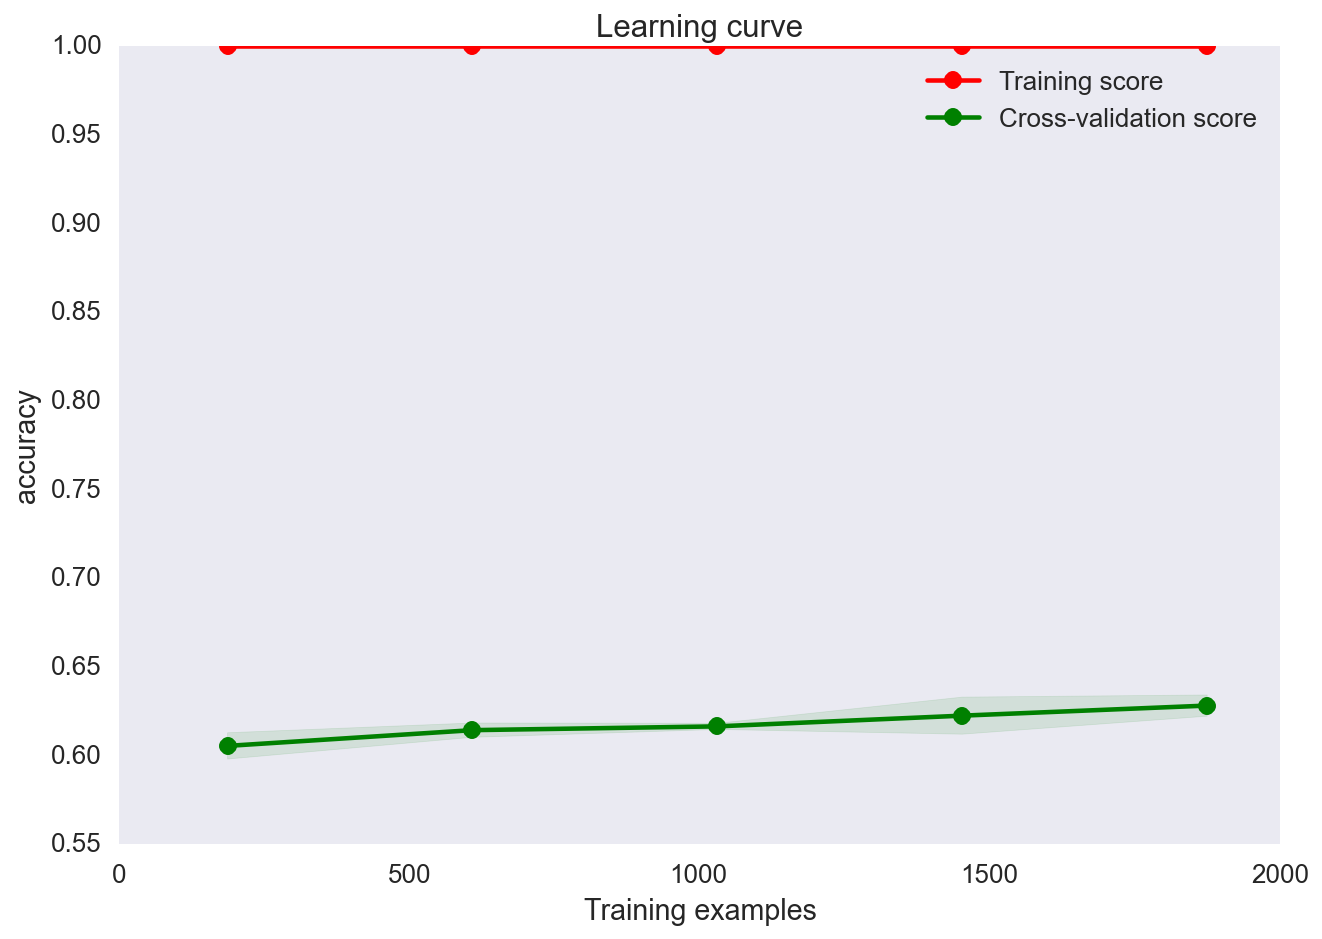

In [77]:
plot_learning_curve(clf4, "Learning curve", Xtr, ytr)

In [87]:
# Yes it's really 100% in training
skl.metrics.accuracy_score(ytr, clf4.predict(Xtr))

[Parallel(n_jobs=4)]: Done   1 out of 1000 | elapsed:    0.0s remaining:   44.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


1.0

In [93]:
clf_dummy = skl.dummy.DummyClassifier(strategy='stratified')
clf_dummy.fit(Xtr, ytr)
skl.metrics.accuracy_score(yte, clf_dummy.predict(Xte), sample_weight=make_weight(yte))

0.35506031673014582

<module 'matplotlib.pyplot' from '/home/ibuder/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

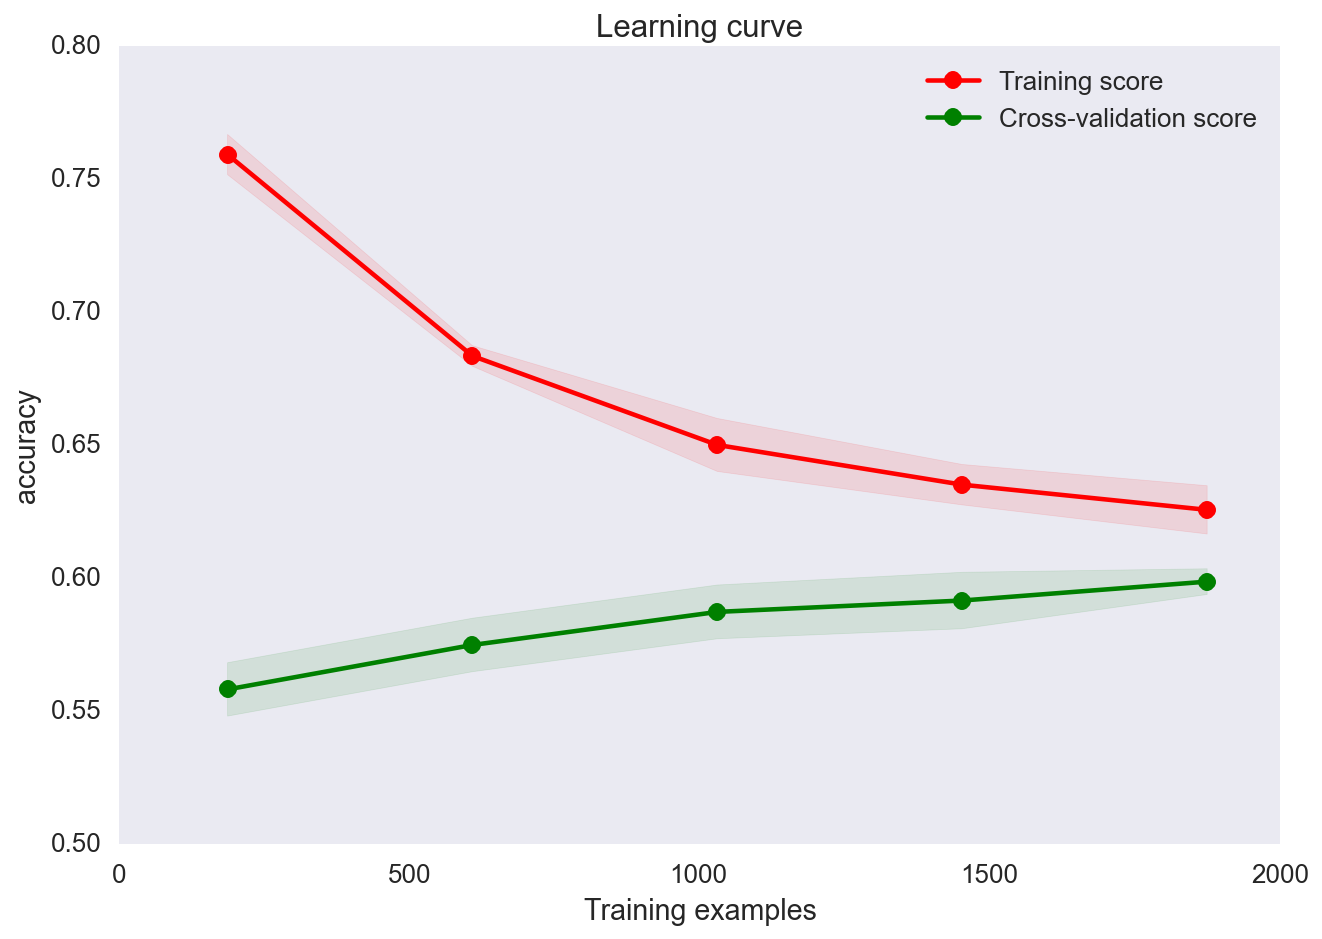

In [95]:
plot_learning_curve(clf1, "Logistic regression cannot improve a lot", Xtr, ytr)

In [68]:
clf4.named_steps['clf'].classes_

array(['4-', '4.5-', '5-'], dtype=object)

([<matplotlib.axis.XTick at 0x7fc87d2ccbe0>,
 <a list of 10 Text xticklabel objects>)

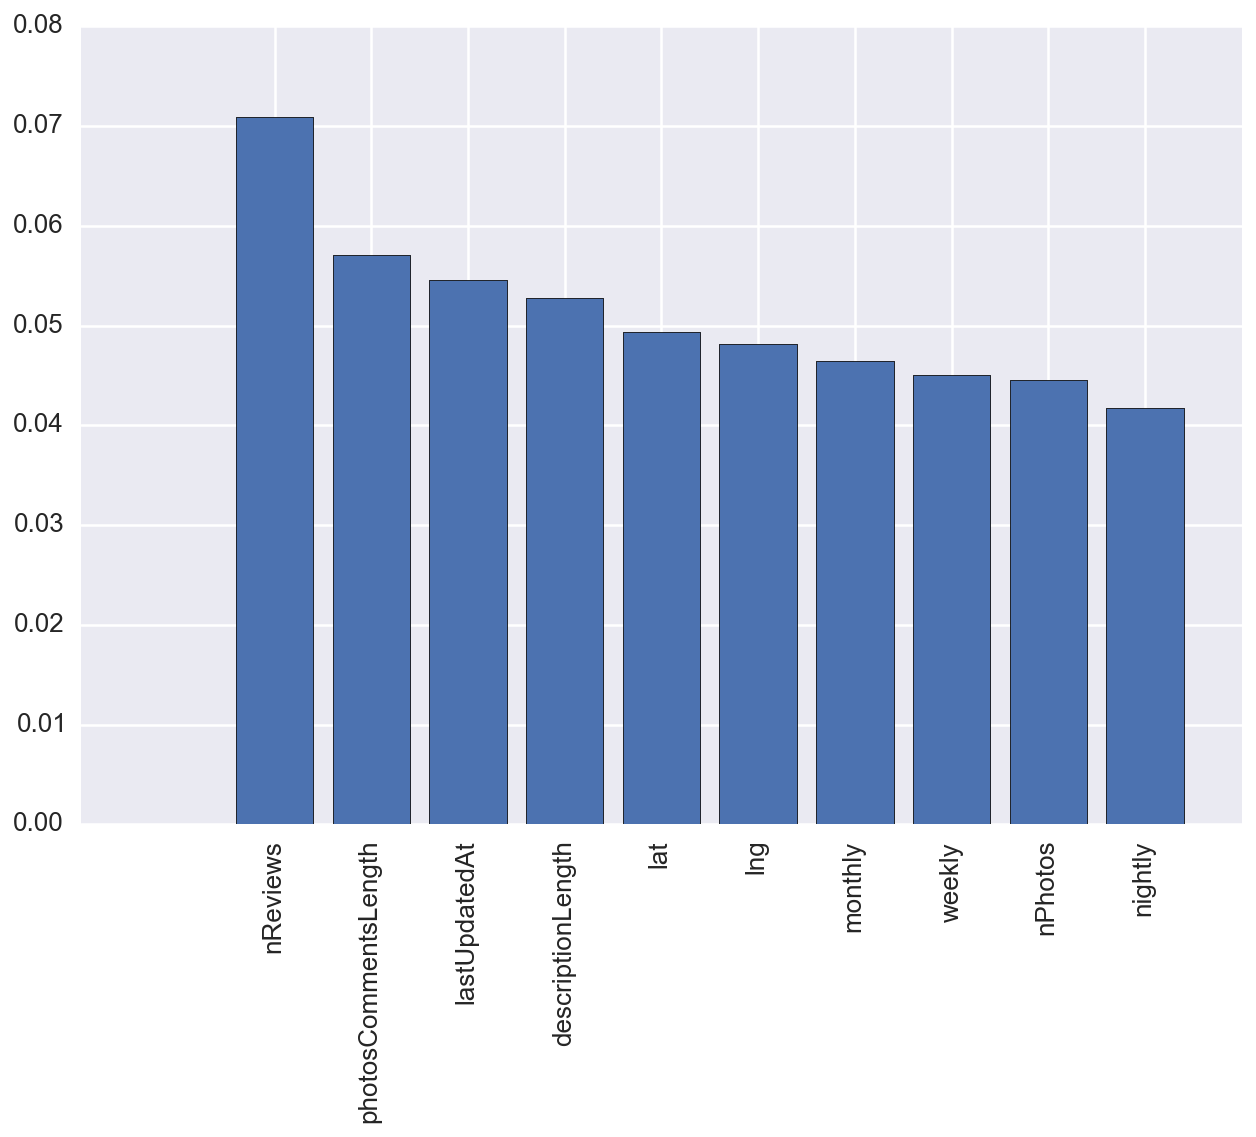

In [111]:
importance = clf4.named_steps['clf'].feature_importances_
ind = importance.argsort()[::-1]  # reverse order
#for p in zip(importance[ind], Xtr.columns[ind]): print(p)
n_features_plot = 10
plt.bar(range(n_features_plot), importance[ind][:n_features_plot], align='center')
plt.xticks(range(n_features_plot), Xtr.columns[ind][:n_features_plot], rotation=90 )

#More features

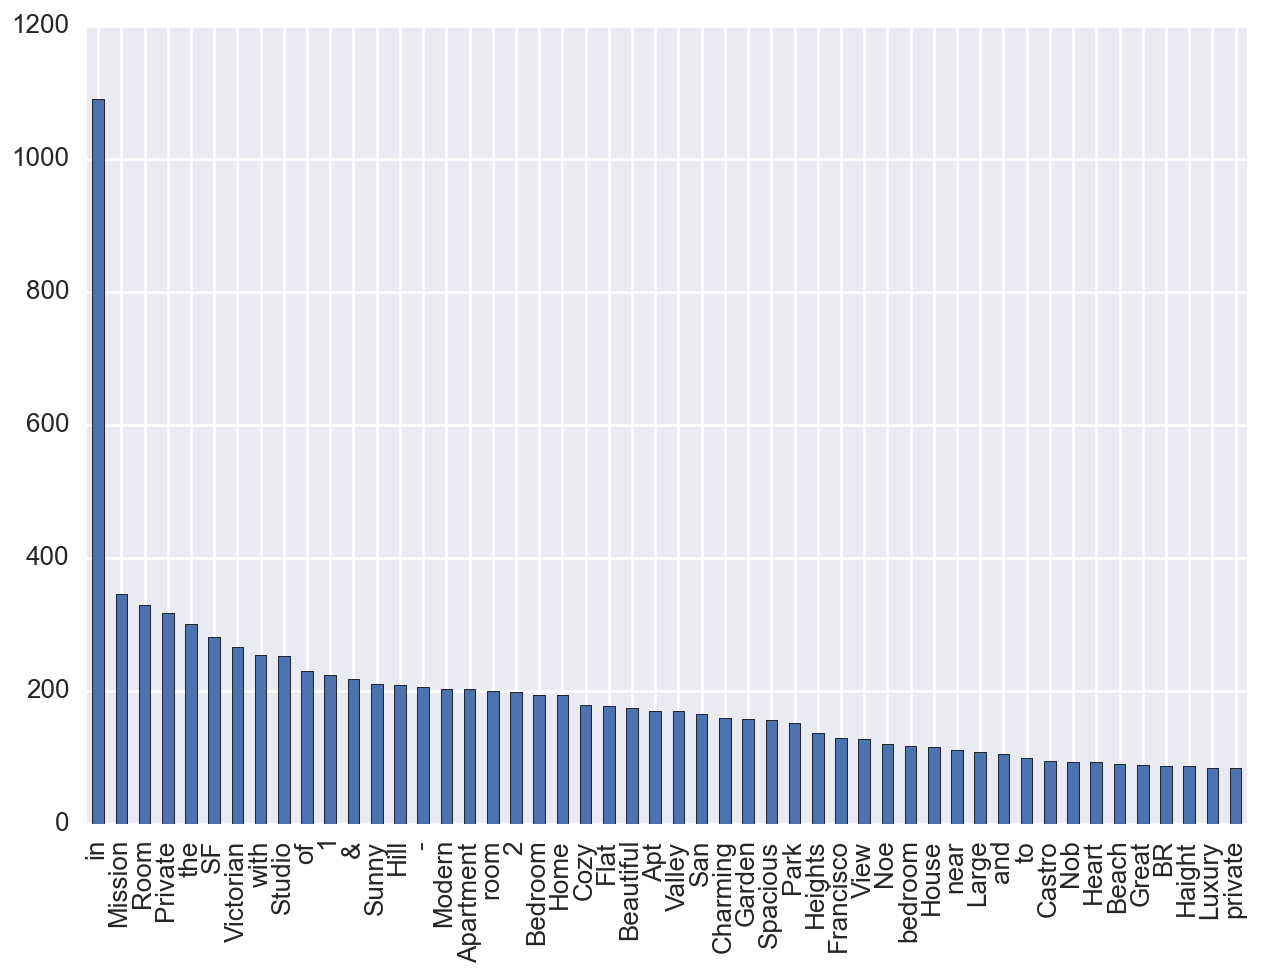

In [19]:
pd.Series(' '.join(rawtable.heading).split()).value_counts().head(50).plot(kind='bar')

In [21]:
pd.Series(' '.join(rawtable.heading).split()).value_counts().head(50).index

Index(['in', 'Mission', 'Room', 'Private', 'the', 'SF', 'Victorian', 'with',
       'Studio', 'of', '1', '&', 'Sunny', 'Hill', '-', 'Modern', 'Apartment',
       'room', '2', 'Bedroom', 'Home', 'Cozy', 'Flat', 'Beautiful', 'Apt',
       'Valley', 'San', 'Charming', 'Garden', 'Spacious', 'Park', 'Heights',
       'Francisco', 'View', 'Noe', 'bedroom', 'House', 'near', 'Large', 'and',
       'to', 'Castro', 'Nob', 'Heart', 'Beach', 'Great', 'BR', 'Haight',
       'Luxury', 'private'],
      dtype='object')

In [28]:
import imp
import learning
imp.reload(learning)
from learning import *
engine = db.create_root_engine()
rawtable = pd.io.sql.read_sql_table('listings', engine, index_col='id')
Xtr3, Xte3, ytr3, yte3 = get_training_test_set(rawtable, make_features=make_features3)

In [109]:
scaler = skl.preprocessing.StandardScaler()
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                              max_features='auto', max_depth=50, # Can experiment with this to regularize
                                              n_jobs=4, class_weight='auto')
clf5 = skl.pipeline.Pipeline([
        ('scaler', scaler), ('clf', clf)])

<module 'matplotlib.pyplot' from '/home/ibuder/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

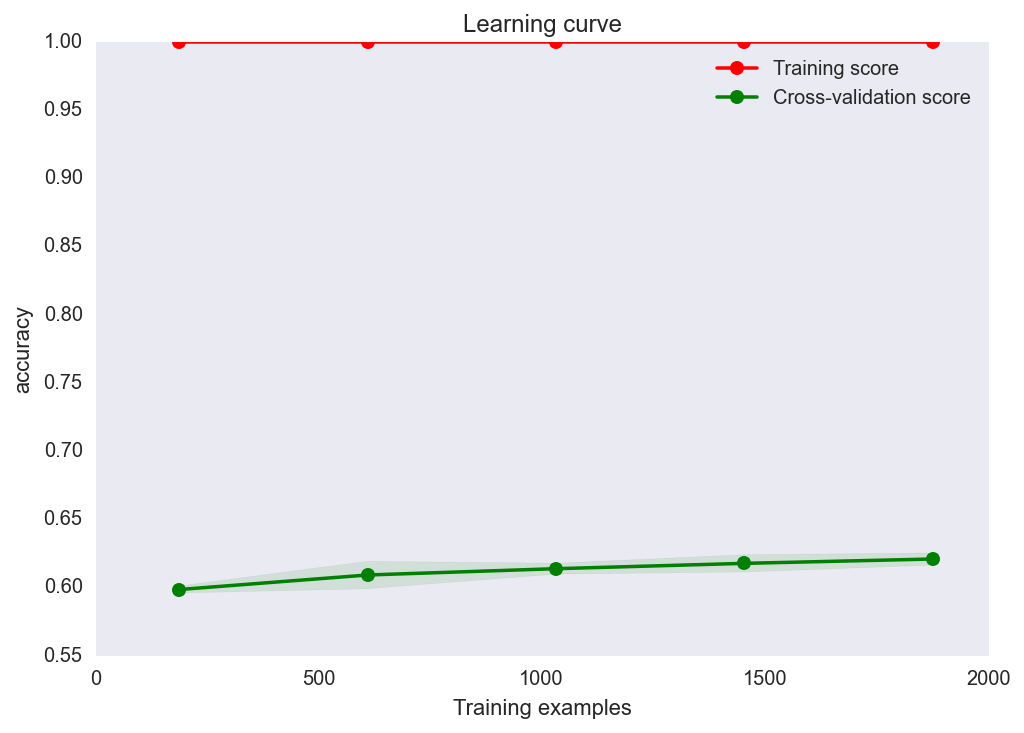

In [110]:
plot_learning_curve(clf5, "Learning curve", Xtr3, ytr3)

In [114]:
clf5.fit(Xtr3, ytr3)
skl.metrics.accuracy_score(yte3, clf5.predict(Xte3))

0.63646055437100213

In [91]:
clf_dummy = skl.dummy.DummyClassifier(strategy='most_frequent')
clf_dummy.fit(Xtr3, ytr3)
skl.metrics.accuracy_score(yte3, clf_dummy.predict(Xte3))

0.59488272921108742

([<matplotlib.axis.XTick at 0x7f5699bcbb70>,
 <a list of 10 Text xticklabel objects>)

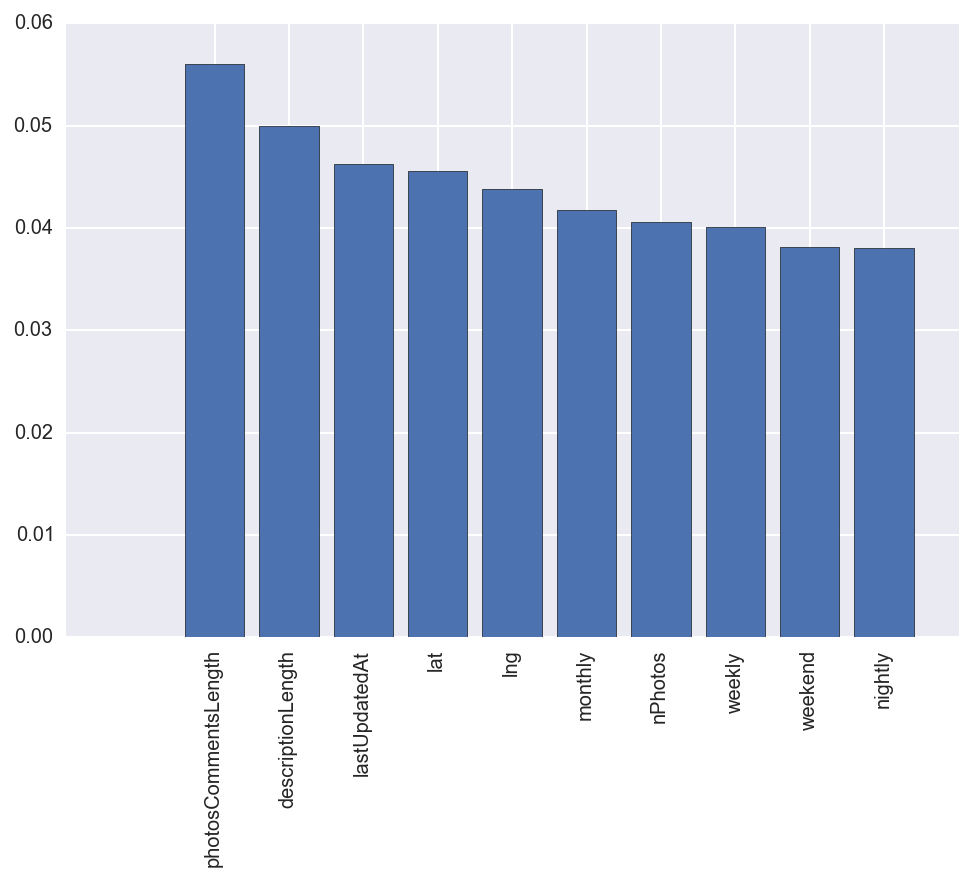

In [119]:
importance = clf5.named_steps['clf'].feature_importances_
ind = importance.argsort()[::-1]  # reverse order
n_features_plot = 10
plt.bar(range(n_features_plot), importance[ind][:n_features_plot], align='center')
plt.xticks(range(n_features_plot), Xtr3.columns[ind][:n_features_plot], rotation=90 )